# **Anime Recommendation System**

<hr>

**<h3> Import required libraries </h3>**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import operator
import time
import math
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

from wordcloud import WordCloud, STOPWORDS

from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Metrics (Computation)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import silhouette_score

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

<hr>

**<h3> Anime Dataset </h3>**

In [2]:
#Read and display dataset using Pandas
anime_dataset = pd.read_csv("anime_dataset.csv",encoding ="latin-1")
display(anime_dataset.head())
print("Number of diffrent Anime Programs: ",anime_dataset.shape[0])
print("Number of features in the dataset: ",anime_dataset.shape[1],anime_dataset.columns.values)

anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                         GintamaÂ°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266

Number of diffrent Anime Programs:  12294
Number of features in the dataset:  7 ['anime_id' 'name' 'genre' 'type' 'episodes' 'rating' 'members']


**<h4>Data Preprocessing</h4>**

In [3]:
print("Data type and Null Values: ")
display(anime_dataset.info())

print("\nStatistics about the dataset: ")
display(anime_dataset["rating"].describe())

Data type and Null Values: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


None


Statistics about the dataset: 


count    12064.000000
mean         6.473902
std          1.026746
min          1.670000
25%          5.880000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

In [4]:
#Drop all null values from the dataset
anime_dataset = anime_dataset.dropna()

#Change unknown "episode" values to 0.
anime_dataset.loc[anime_dataset["episodes"] == "Unknown", "episodes"] = 0
anime_dataset["episodes"] = anime_dataset["episodes"].astype(int)

<hr>

**<h3> Rating Dataset </h3>**

In [5]:
rating_dataset = pd.read_csv("rating_dataset.csv")
display(rating_dataset.head())
print("Number of entries in the dataset: ",rating_dataset.shape[0])
print("Number of features in the dataset: ",rating_dataset.shape[1])
print("The features are: ",rating_dataset.columns.values)

user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1

Number of entries in the dataset:  7813737
Number of features in the dataset:  3
The features are:  ['user_id' 'anime_id' 'rating']


<hr>

**<h3>Final Dataset</h3>**

We will now merge the two datasets "anime_dataset" and "rating_dataset" and create a new dataset "final_dataset" which will be used to train our DM/ML models.

In [6]:
final_dataset = pd.merge(anime_dataset,rating_dataset[["user_id","anime_id","rating"]], on = ["anime_id"],how = "right")
final_dataset.rename(columns = {'rating_x':'AverageRating','rating_y':'rating'}, inplace = True)
#Drop rows with null Average Rating
final_dataset.dropna(inplace=True)

print("Final Dataset: ")
display(final_dataset.head(10))

Final Dataset: 


anime_id                                               name  \
0        20                                             Naruto   
1        24                                      School Rumble   
2        79                                           Shuffle!   
3       226                                         Elfen Lied   
4       241                          Girls Bravo: First Season   
5       355                                  Shakugan no Shana   
6       356                                    Fate/stay night   
7       442  Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shin...   
8       487                         Girls Bravo: Second Season   
9       846                             School Rumble Ni Gakki   

                                               genre   type  episodes  \
0  Action, Comedy, Martial Arts, Shounen, Super P...     TV     220.0   
1                   Comedy, Romance, School, Shounen     TV      26.0   
2  Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...     TV      24.0   
3  Action, Drama, Horror, Psychological, Romance,...     TV      13.0   
4     Comedy, Ecchi, Fantasy, Harem, Romance, School     TV      11.0   
5  Action, Drama, Fantasy, Romance, School, Super...     TV      24.0   
6      Action, Fantasy, Magic, Romance, Supernatural     TV      24.0   
7  Adventure, Comedy, Drama, Historical, Shounen,...  Movie       1.0   
8     Comedy, Ecchi, Fantasy, Harem, Romance, School     TV      13.0   
9                   Comedy, Romance, School, Shounen     TV      26.0   

   AverageRating   members  user_id  rating  
0           7.81  683297.0        1      -1  
1           8.06  178553.0        1      -1  
2           7.31  158772.0        1      -1  
3           7.85  623511.0        1      -1  
4           6.69   84395.0        1      -1  
5           7.74  297058.0        1      -1  
6           7.58  374880.0        1      -1  
7           7.17  120571.0        1      -1  
8           6.90   57110.0        1      -1  
9           8.15   93095.0        1      -1

<hr>

**<h3> Explonatory Data Analysis (EDA) </h3>**

**1) Top 10 and bottom 10 Anime programs based on average rating**

index  anime_id                                               name  \
0   8795     23005                                   Mogura no Motoro   
1  10747     32281                                     Kimi no Na wa.   
2   3965      5114                   Fullmetal Alchemist: Brotherhood   
3   9831     28977                                          GintamaÂ°   
4   9499     26313                    Yakusoku: Africa Mizu to Midori   
5   5673      9253                                        Steins;Gate   
6   5997      9969                                      Gintama&#039;   
7  10935     32935  Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...   
8   6465     11061                             Hunter x Hunter (2011)   
9   7249     15417                           Gintama&#039;: Enchousen   

                                               genre  AverageRating  
0                                      Slice of Life           9.50  
1               Drama, Romance, School, Supernatural           9.37  
2  Action, Adventure, Drama, Fantasy, Magic, Mili...           9.26  
3  Action, Comedy, Historical, Parody, Samurai, S...           9.25  
4                                        Drama, Kids           9.25  
5                                   Sci-Fi, Thriller           9.17  
6  Action, Comedy, Historical, Parody, Samurai, S...           9.16  
7             Comedy, Drama, School, Shounen, Sports           9.15  
8            Action, Adventure, Shounen, Super Power           9.13  
9  Action, Comedy, Historical, Parody, Samurai, S...           9.11

index  anime_id                                 name  \
11152  10784     32388  Undouki Kenshin Manual Taiou Taisou   
11153  10051     29949                                 Nami   
11154  10573     31634                             Kokuhaku   
11155   9087     24259     Mechano: Scientific Attack Force   
11156   7166     14781              Roboteuwang Sseonsyakeu   
11157    385       413                      Hametsu no Mars   
11158   6960     13405                   Utsu Musume Sayuri   
11159   2929      3287         Tenkuu Danzai Skelter+Heaven   
11160   8188     20007        Hi Gekiga Ukiyoe Senya Ichiya   
11161  11160     34476   Platonic Chain: Ansatsu Jikkouchuu   

                                                  genre  AverageRating  
11152                                              Kids           2.72  
11153                                          Dementia           2.67  
11154                                            Horror           2.67  
11155  Comedy, Dementia, Fantasy, Horror, Music, Parody           2.55  
11156                             Action, Mecha, Sci-Fi           2.49  
11157                                    Horror, Sci-Fi           2.37  
11158                                  Comedy, Dementia           2.14  
11159                                     Mecha, Sci-Fi           2.00  
11160                                    Action, Hentai           1.92  
11161                             Sci-Fi, Slice of Life           1.67

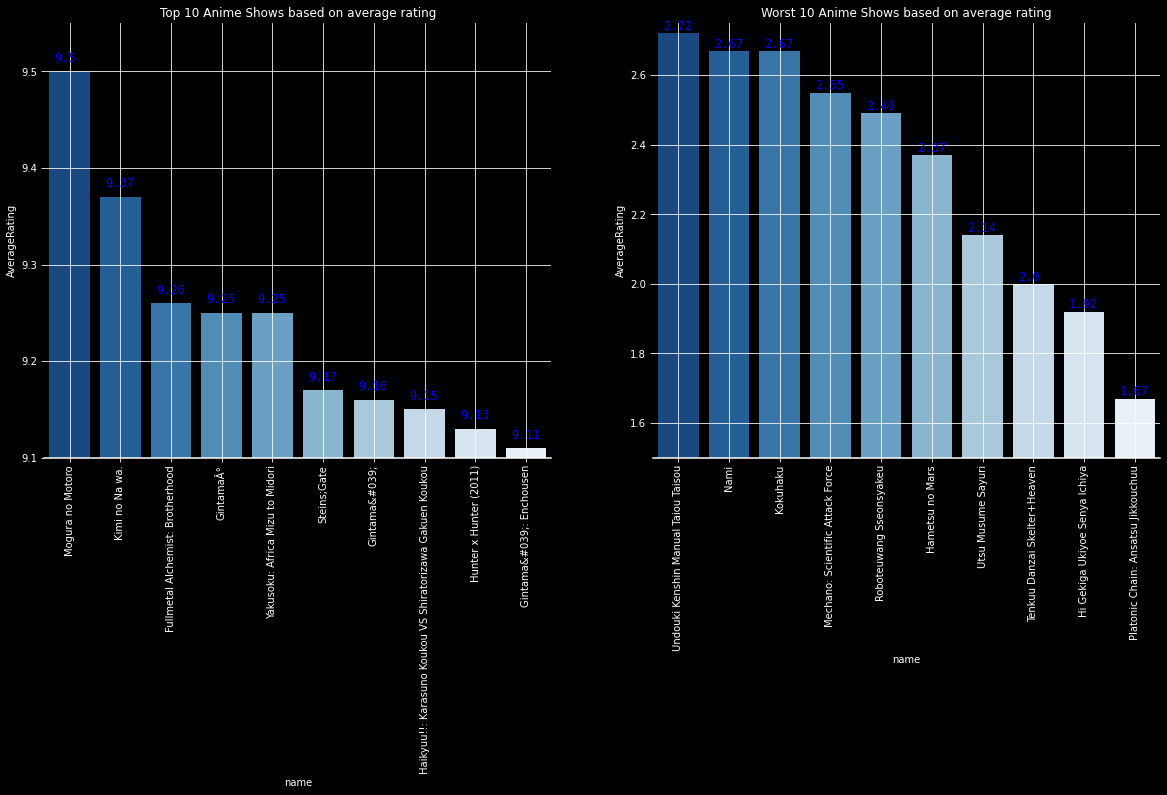

In [7]:
#Average Rating of each Anime
grouped_by_anime_id = final_dataset.groupby(["anime_id","name","genre"])[["AverageRating"]].mean().reset_index()
sorted_grouped_by_anime_id = grouped_by_anime_id.sort_values(by = ["AverageRating"],ascending=False).reset_index()

#Plot top 10 based on average rating of each show.
display(sorted_grouped_by_anime_id.head(10))
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
A = sns.barplot(sorted_grouped_by_anime_id.name[:10], sorted_grouped_by_anime_id["AverageRating"][:10], palette ="Blues_r")
A.spines['bottom'].set_linewidth(1.5)
for w in ['right', 'top', 'left']:
    A.spines[w].set_visible(False)
plt.title("Top 10 Anime Shows based on average rating")
plt.ylim(9.1,9.55)
plt.xticks(rotation=90)
plt.grid()

k=0
for p in A.patches:
    height = p.get_height()
    plt.text(p.get_x()+0.1,height+0.01, sorted_grouped_by_anime_id["AverageRating"][k],fontname = 'monospace', fontsize = 12, color = 'Blue') 
    k+=1


#Plot worst 10 anime shows based on average ratings
display(sorted_grouped_by_anime_id.tail(10))
plt.subplot(1, 2, 2)
B = sns.barplot(sorted_grouped_by_anime_id.name[11152:11162],sorted_grouped_by_anime_id["AverageRating"][11152:11162],palette="Blues_r")
B.spines['bottom'].set_linewidth(1.5)
for w in ['right', 'top', 'left']:
    B.spines[w].set_visible(False)
    
k=11152
for p in B.patches:
    height = p.get_height()
    plt.text(p.get_x()+0.1,height+0.01, sorted_grouped_by_anime_id["AverageRating"][k],fontname = 'monospace', fontsize = 12, color = 'Blue') 
    k+=1
plt.title("Worst 10 Anime Shows based on average rating")
plt.ylim(1.5,2.75)
plt.xticks(rotation=90)
plt.grid()
plt.show()

**2) Distribution of Average Ratings**

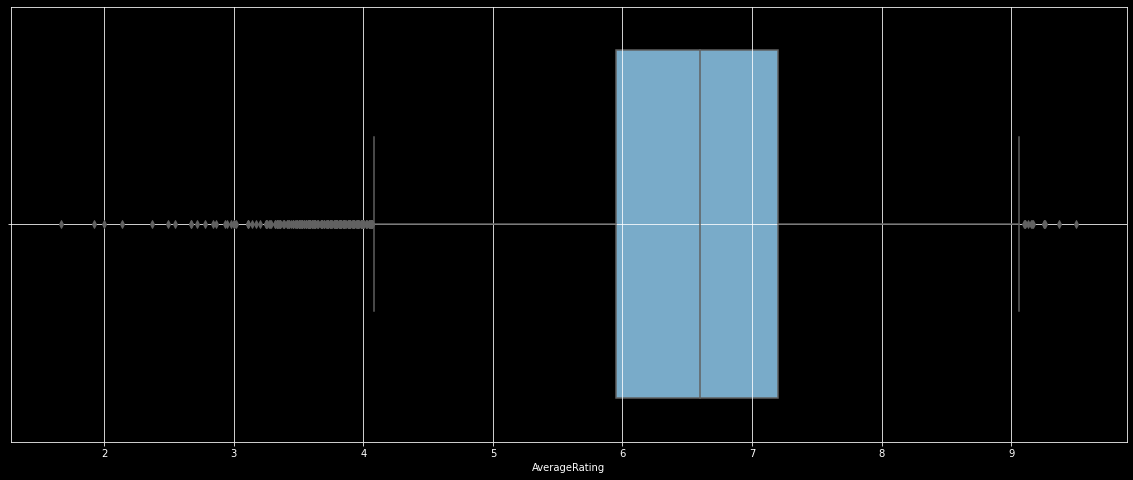

In [8]:
plt.figure(figsize=(20,8))
sns.boxplot(grouped_by_anime_id["AverageRating"],palette="Blues_r",orient="v")
plt.grid()
plt.show()

- This shows that most average ratings are between 4 and 9 with 6-7 being the most dense area.
- There are many outliers in the data below 4 and more than 9

<hr>

**3) Word Cloud for Genre column** <br>
This will visualize the most common genres in the top 100 animes watched by users

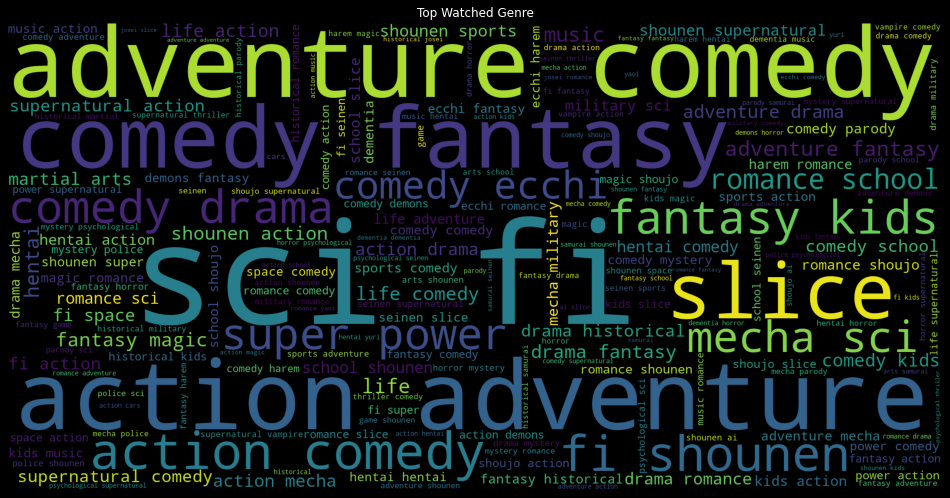

In [9]:
genres = sorted_grouped_by_anime_id["genre"]

comment_words = ''
stopwords = set(STOPWORDS)
 
for genre in genres:
 
    genre = str(genre)
    # split the different genres
    tokens = genre.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 2000, height = 1000, background_color ='black', stopwords = stopwords, min_font_size = 10).generate(comment_words)
    
#Plot the wordcloud
plt.figure(figsize = (13, 10), facecolor = None)
plt.imshow(wordcloud)
plt.title("Top Watched Genre")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

<hr>

**4) Group the Anime based on "Type"**

The different type of Anime Shows are:  ['TV' 'Movie' 'OVA' 'Special' 'ONA' 'Music']


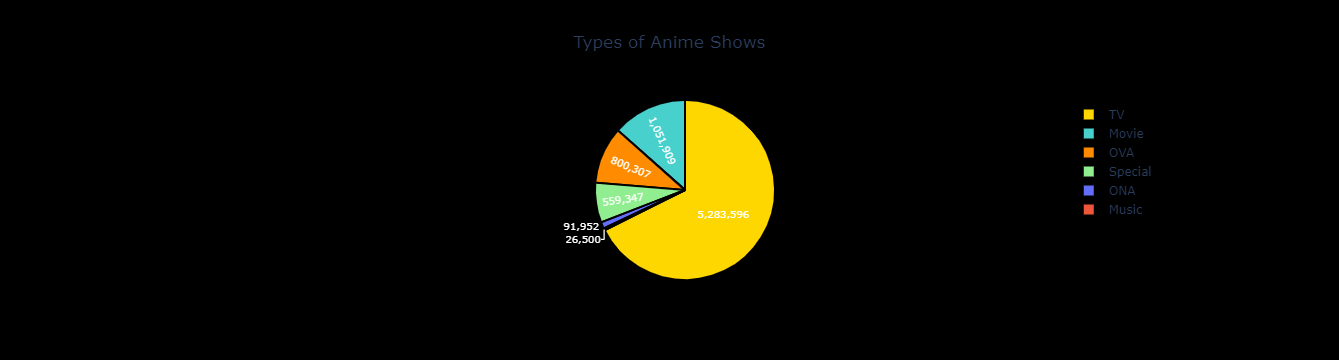

In [10]:
anime_type = final_dataset["type"]
print("The different type of Anime Shows are: ",anime_type.unique())

labels = anime_type.value_counts().index
values = anime_type.value_counts().values

#Visualize the different types
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=10,textfont_color = "white",
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(
    title={
        'text': "Types of Anime Shows",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        paper_bgcolor="black")

fig.show()

Average Rating based on type: 
TV : 7.739
Movie : 7.81
Special : 7.331
OVA : 7.196
ONA : 7.053
Music : 7.033


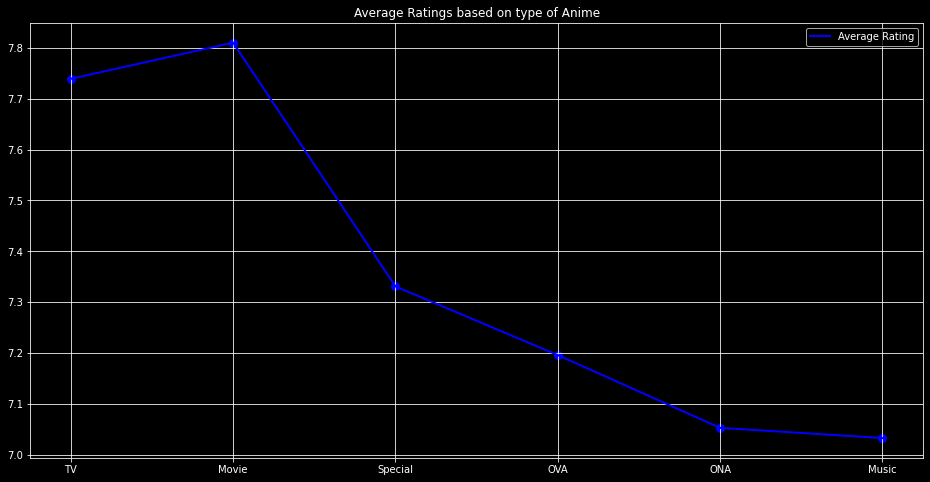

In [11]:
#Split dataset based on different types of anime
mean_avgrat_type = [round(final_dataset[final_dataset["type"] == "TV"]["AverageRating"].mean(),3),
                    round(final_dataset[final_dataset["type"] == "Movie"]["AverageRating"].mean(),3),
                    round(final_dataset[final_dataset["type"] == "Special"]["AverageRating"].mean(),3),
                    round(final_dataset[final_dataset["type"] == "OVA"]["AverageRating"].mean(),3),
                    round(final_dataset[final_dataset["type"] == "ONA"]["AverageRating"].mean(),3),
                    round(final_dataset[final_dataset["type"] == "Music"]["AverageRating"].mean(),3)]

labels = ["TV","Movie","Special","OVA","ONA","Music"]
print("Average Rating based on type: ")
for i in range(6):
    print(labels[i],":",mean_avgrat_type[i])
    
#Plot the average rating of every type.
plt.figure(figsize = (16,8))
plt.plot(["TV","Movie","Special","OVA","ONA","Music"],mean_avgrat_type,label = "Average Rating", c = "Blue",linewidth = 2)
plt.scatter(labels,mean_avgrat_type, c = "Blue",linewidth = 3)
plt.title("Average Ratings based on type of Anime")
plt.grid()
plt.legend()
plt.show()

<h3> Now let's look at the top 100 Anime shows based on average rating </h3>

In [12]:
top_100_anime_shows = final_dataset.groupby(["anime_id","name","genre","episodes"])[["AverageRating"]].mean().reset_index()
sorted_top_100_anime_shows = top_100_anime_shows.sort_values(by = ["AverageRating"],ascending=False).reset_index()[:100]
display(sorted_top_100_anime_shows)

index  anime_id                                   name  \
0    8795     23005                       Mogura no Motoro   
1   10747     32281                         Kimi no Na wa.   
2    3965      5114       Fullmetal Alchemist: Brotherhood   
3    9831     28977                              GintamaÂ°   
4    9499     26313        Yakusoku: Africa Mizu to Midori   
..    ...       ...                                    ...   
95   4381      5941                             Cross Game   
96   6026     10030                    Bakuman. 2nd Season   
97  10201     30346                     Doukyuusei (Movie)   
98   3273      3784  Evangelion: 2.0 You Can (Not) Advance   
99   7124     14397                          Chihayafuru 2   

                                                genre  episodes  AverageRating  
0                                       Slice of Life       1.0           9.50  
1                Drama, Romance, School, Supernatural       1.0           9.37  
2   Action, Adventure, Drama, Fantasy, Magic, Mili...      64.0           9.26  
3   Action, Comedy, Historical, Parody, Samurai, S...      51.0           9.25  
4                                         Drama, Kids       1.0           9.25  
..                                                ...       ...            ...  
95             Comedy, Drama, Romance, School, Sports      50.0           8.53  
96                    Comedy, Drama, Romance, Shounen      25.0           8.53  
97         Romance, School, Shounen Ai, Slice of Life       1.0           8.53  
98                              Action, Mecha, Sci-Fi       1.0           8.53  
99          Drama, Game, Josei, Slice of Life, Sports      25.0           8.52  

[100 rows x 6 columns]

<hr>

**Generate Word Cloud to visualize popular genres**

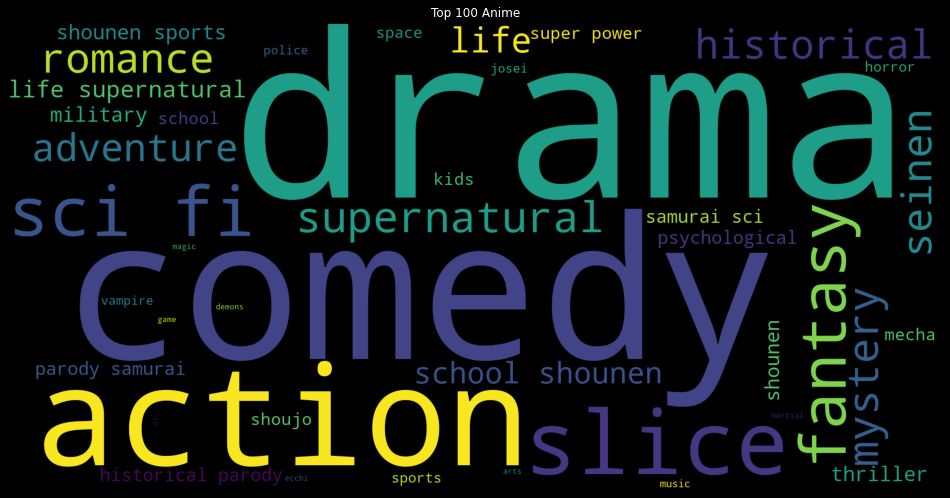

In [13]:
genres = sorted_top_100_anime_shows["genre"]

comment_words = ''
stopwords = set(STOPWORDS)
 
for genre in genres:
 
    genre = str(genre)
    # split the different genres
    tokens = genre.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
    
wordcloud = WordCloud(width = 2000, height = 1000, background_color ='black', stopwords = stopwords, min_font_size = 10).generate(comment_words)
    
#Plot the wordcloud
plt.figure(figsize = (13, 10), facecolor = None)
plt.imshow(wordcloud)
plt.title("Top 100 Anime")
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

- The most popular genres are "Action", "Drama", "Comedy", and "Sci-Fi".

<hr>

**Number of episodes in top 100 animes**

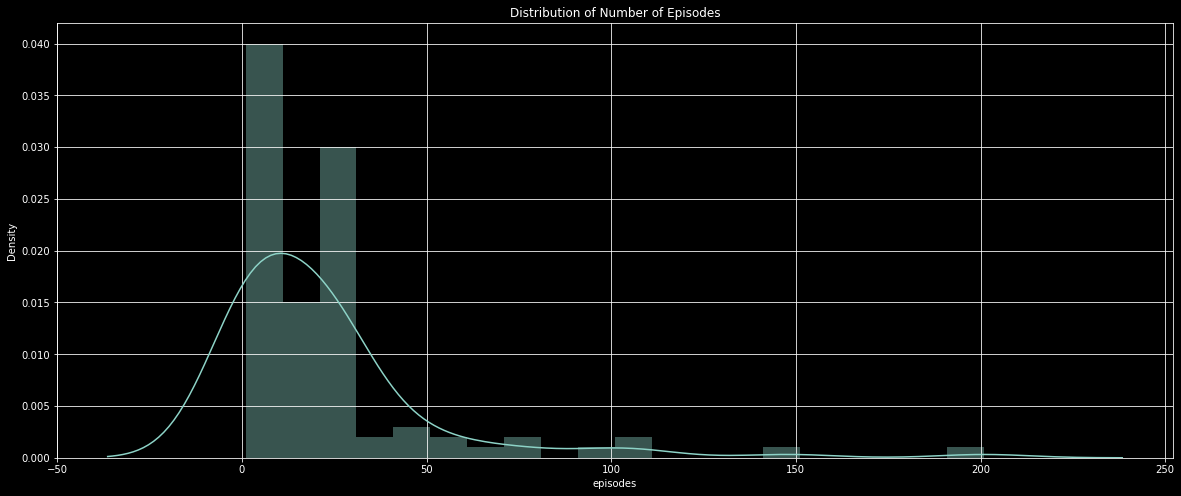

In [14]:
#Plot Distribution plots and box plots
plt.figure(figsize=(20,8))
sns.distplot(sorted_top_100_anime_shows["episodes"])
plt.title("Distribution of Number of Episodes")
plt.grid()
plt.show()

- The plot suggest that the most popular anime shows have 1-50 episodes with denser population between 1-25.

<hr>

**<h3>K-Means Clustering</h3>**

In [15]:
clustering_data = final_dataset[:100000]
user_anime_crosstab = pd.crosstab(clustering_data['user_id'],clustering_data['name'])
user_anime_crosstab.head()

name     &quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi  \
user_id                                                        
1                                                        0     
2                                                        0     
3                                                        0     
4                                                        0     
5                                                        0     

name     &quot;Bungaku Shoujo&quot; Memoire  &quot;Bungaku Shoujo&quot; Movie  \
user_id                                                                         
1                                         0                                 0   
2                                         0                                 0   
3                                         0                                 0   
4                                         0                                 0   
5                                         0                                 0   

name     .hack//G.U. Returner  .hack//G.U. Trilogy  \
user_id                                              
1                           0                    0   
2                           0                    0   
3                           0                    0   
4                           0                    0   
5                           0                    0   

name     .hack//G.U. Trilogy: Parody Mode  .hack//Gift  .hack//Intermezzo  \
user_id                                                                     
1                                       0            0                  0   
2                                       0            0                  0   
3                                       0            0                  0   
4                                       0            0                  0   
5                                       0            0                  0   

name     .hack//Liminality  .hack//Quantum  ...  gdgd Fairies  gdgd Fairies 2  \
user_id                                     ...                                 
1                        0               0  ...             0               0   
2                        0               0  ...             0               0   
3                        0               0  ...             0               0   
4                        0               0  ...             0               0   
5                        0               0  ...             0               0   

name     gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?  \
user_id                                                    
1                                                      0   
2                                                      0   
3                                                      0   
4                                                      0   
5                                                      0   

name     iDOLM@STER Xenoglossia  s.CRY.ed  xxxHOLiC  xxxHOLiC Kei  \
user_id                                                             
1                             0         0         0             0   
2                             0         0         0             0   
3                             0         0         0             0   
4                             0         0         0             0   
5                             0         0         1             0   

name     xxxHOLiC Movie: Manatsu no Yoru no Yume  xxxHOLiC Rou  \
user_id                                                          
1                                              0             0   
2                                              0             0   
3                                              0             0   
4                                              0             0   
5                                              0             0   

name     xxxHOLiC Shunmuki  
user_id                     
1                        0  
2                        0  
3           

In [16]:
#Apply PCA analysis to reduce dimension of the data
pca = PCA(n_components=3)
pca.fit(user_anime_crosstab)
pca_samples = pca.transform(user_anime_crosstab)

ps = pd.DataFrame(pca_samples)
display(ps.head())

tocluster = pd.DataFrame(ps[[0,1,2]])

0         1         2
0  3.104374 -4.178276 -0.766992
1 -2.757186 -0.711534  0.627758
2  0.288553  1.007527  0.784847
3 -0.952593 -0.316322 -0.648251
4  9.503828 -2.394965 -0.847646

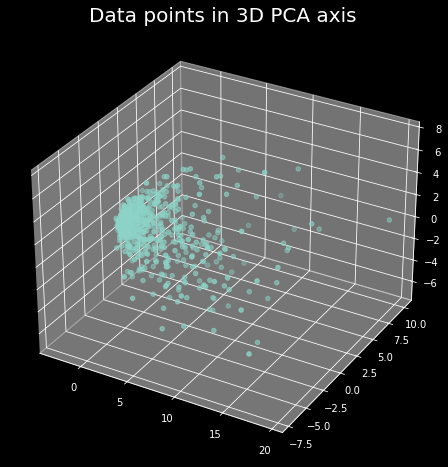

In [17]:
plt.rcParams['figure.figsize'] = (14, 6)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

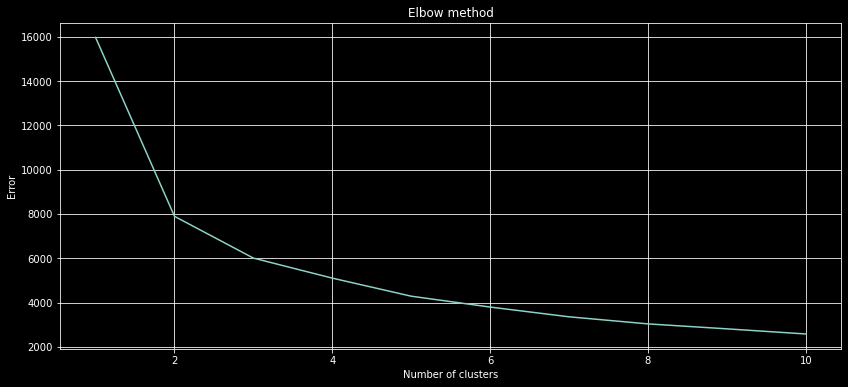

In [18]:
#Elbow method - Choose the optimum value of K
Error =[]

for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(tocluster)
    kmeans.fit(tocluster)
    Error.append(kmeans.inertia_)
    
plt.plot(range(1,11),Error)
plt.title("Elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("Error")
plt.grid()
plt.show()

In [19]:
#Build cluster model and fit data to it
clustering_model = KMeans(n_clusters=3,random_state=30)
clustering_model.fit(tocluster)

centers = clustering_model.cluster_centers_
c_preds = clustering_model.predict(tocluster)

print(centers)

[[ 8.12070125 -1.38294836  0.55787832]
 [-1.83567998 -0.14012377  0.09656987]
 [ 2.09586637  0.90597785 -0.47717183]]


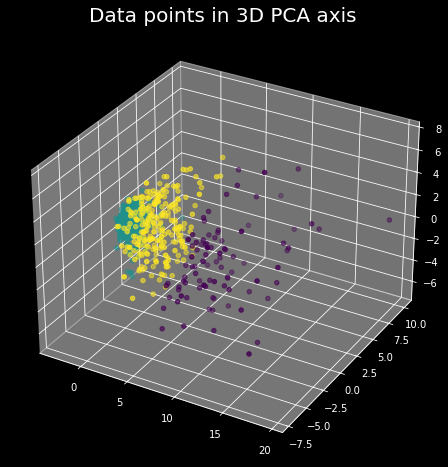

In [20]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

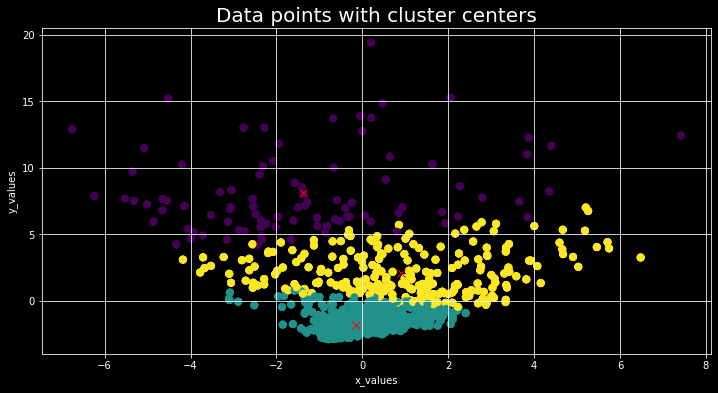

In [21]:
fig = plt.figure(figsize=(12,6))
# plt.scatter(tocluster[1],tocluster[0], s = 40, c = 'purple', alpha=0.5, marker="x")

for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'x', markersize=8, color='red', alpha=1)
    plt.scatter(tocluster[1],tocluster[0],c = c_preds,s=50,marker="o")

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points with cluster centers', fontsize=20)
plt.grid()
plt.show()

In [22]:
user_anime_crosstab['cluster'] = c_preds

c0 = user_anime_crosstab[user_anime_crosstab['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime_crosstab[user_anime_crosstab['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime_crosstab[user_anime_crosstab['cluster']==2].drop('cluster',axis=1).mean()
c3 = user_anime_crosstab[user_anime_crosstab['cluster']==3].drop('cluster',axis=1).mean()

In [23]:
c0.sort_values(ascending=False)[0:15]

name
Sword Art Online                                       0.956522
Yahari Ore no Seishun Love Comedy wa Machigatteiru.    0.902174
No Game No Life                                        0.891304
Date A Live                                            0.891304
Shingeki no Kyojin                                     0.869565
Angel Beats!                                           0.869565
High School DxD                                        0.858696
Chuunibyou demo Koi ga Shitai!                         0.858696
Mirai Nikki (TV)                                       0.847826
Boku wa Tomodachi ga Sukunai                           0.826087
Sakurasou no Pet na Kanojo                             0.826087
Toradora!                                              0.815217
Tokyo Ghoul                                            0.815217
High School DxD New                                    0.815217
Highschool of the Dead                                 0.815217
dtype: float64

<hr>

**<h3> Collaborative Filtering</h3>**

1) **User-User CF**

In [24]:
CF_dataset = final_dataset[final_dataset["rating"] != -1][["name","anime_id","user_id","rating","AverageRating"]]
CF_dataset = CF_dataset[CF_dataset.user_id <= 10000]
display(CF_dataset.head())
CF_dataset.shape

name  anime_id  user_id  rating  AverageRating
47   Highschool of the Dead      8074        1      10           7.46
81          High School DxD     11617        1      10           7.70
83         Sword Art Online     11757        1      10           7.83
101     High School DxD New     15451        1      10           7.87
153        Kuroko no Basket     11771        2      10           8.46

(849155, 5)

In [25]:
grouped_userid = CF_dataset.groupby(by="user_id",as_index=False)["rating"].mean()
#For each user find the standard deviation of ratings
Mean = CF_dataset.groupby(by="user_id",as_index=False)['rating'].mean()
Std = CF_dataset.groupby(by="user_id",as_index=False)["rating"].std()
CF_dataset = pd.merge(CF_dataset,Std,on="user_id")
CF_dataset = CF_dataset[CF_dataset["rating_y"] != 0 ]
CF_dataset.rename(columns = {'rating_x':'rating','rating_y':'StdRating'}, inplace = True)

CF_dataset["z_score"] = (CF_dataset["rating"] - CF_dataset["AverageRating"]) / CF_dataset["StdRating"]
CF_dataset.head()

name  anime_id  user_id  rating  AverageRating  \
4               Kuroko no Basket     11771        2      10           8.46   
5                         Naruto        20        3       8           7.81   
6                    Shaman King       154        3       6           7.83   
7                      Slam Dunk       170        3       9           8.56   
8  Sen to Chihiro no Kamikakushi       199        3      10           8.93   

   StdRating   z_score  
4        NaN       NaN  
5   1.549933  0.122586  
6   1.549933 -1.180696  
7   1.549933  0.283883  
8   1.549933  0.690352

In [26]:
#Create pivot table 
user_rating_z = pd.pivot_table(CF_dataset, values = "z_score", index = "user_id", columns="anime_id").fillna(0)
user_rating_z.head()

anime_id  1      5         6      7      8         15     16        17     \
user_id                                                                     
3           0.0    0.0  0.000000    0.0    0.0  0.000000    0.0  0.000000   
5           0.0    0.0 -0.134381    0.0    0.0 -0.873475    0.0 -0.730695   
7           0.0    0.0  0.000000    0.0    0.0  0.000000    0.0  0.000000   
8           0.0    0.0  0.000000    0.0    0.0  0.000000    0.0  0.000000   
10          0.0    0.0  0.000000    0.0    0.0  0.000000    0.0  0.000000   

anime_id     18     19     ...  34015  34048  34085  34103  34107  34136  \
user_id                    ...                                             
3         0.000000    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
5        -0.940665    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
7         0.000000    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
8         0.000000    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   
10        0.000000    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  34240  34283  34324  34325  
user_id                               
3           0.0    0.0    0.0    0.0  
5           0.0    0.0    0.0    0.0  
7           0.0    0.0    0.0    0.0  
8           0.0    0.0    0.0    0.0  
10          0.0    0.0    0.0    0.0  

[5 rows x 7922 columns]

**Similarity Metric - Cosine Similarity**

In [27]:
#Calculate User-User similarity using Cosine function
cosine_similarity_user = cosine_similarity(user_rating_z)
np.fill_diagonal(cosine_similarity_user,0)

#Create a pandas dataframe to store the user_similarity values
user_similarity=pd.DataFrame(cosine_similarity_user,index=user_rating_z.index)
user_similarity.columns=user_rating_z.index
user_similarity.head()

user_id     3         5         7         8         10        11        12     \
user_id                                                                         
3        0.000000 -0.031012  0.083307  0.017087  0.057609  0.016967  0.133947   
5       -0.031012  0.000000  0.040720 -0.065072 -0.044935  0.021692 -0.012747   
7        0.083307  0.040720  0.000000 -0.004649 -0.052201 -0.041876  0.011144   
8        0.017087 -0.065072 -0.004649  0.000000  0.119918  0.024581  0.056527   
10       0.057609 -0.044935 -0.052201  0.119918  0.000000  0.010586  0.119548   

user_id     14        16        17     ...     9991      9992      9993   \
user_id                                ...                                 
3       -0.033227  0.012945  0.061075  ... -0.137451 -0.036627 -0.017761   
5        0.214909  0.003330  0.185635  ...  0.005620 -0.066185  0.022963   
7        0.027641 -0.046563  0.019115  ...  0.000000  0.000000  0.004314   
8       -0.106091  0.000000 -0.024338  ... -0.036932  0.000000  0.000774   
10      -0.094572  0.000000  0.010677  ...  0.000000  0.000000  0.000000   

user_id     9994      9995      9996      9997      9998      9999      10000  
user_id                                                                        
3       -0.001565 -0.031634 -0.003979 -0.029211 -0.059108  0.031464  0.042203  
5       -0.022867  0.308811 -0.007599 -0.051717 -0.020435 -0.045039 -0.033074  
7        0.006395  0.019405  0.058529  0.028329  0.036591  0.003843  0.019279  
8        0.058103 -0.014307 -0.055498  0.000000 -0.042307  0.005158  0.125412  
10       0.032896 -0.020660 -0.042625  0.000000 -0.166015  0.012693  0.093106  

[5 rows x 8661 columns]

In [28]:
#Calculate item-item cosine similarity
cosine_similarity_item = cosine_similarity(user_rating_z.T)
item_similarity=pd.DataFrame(cosine_similarity_item,index=user_rating_z.T.index)
item_similarity.columns=user_rating_z.T.index
item_similarity.head()

anime_id     1         5         6         7         8         15     \
anime_id                                                               
1         1.000000  0.402921  0.295161  0.249282  0.010525  0.230975   
5         0.402921  1.000000  0.369538  0.472714 -0.014298  0.439683   
6         0.295161  0.369538  1.000000  0.411915  0.013065  0.380125   
7         0.249282  0.472714  0.411915  1.000000  0.007700  0.583903   
8         0.010525 -0.014298  0.013065  0.007700  1.000000  0.032535   

anime_id     16        17        18        19     ...     34015     34048  \
anime_id                                          ...                       
1         0.056136 -0.027106  0.278108  0.100878  ...  0.022299 -0.004362   
5         0.027458 -0.007027  0.482074  0.051273  ...  0.000000  0.013747   
6         0.044351  0.024847  0.412997  0.057137  ...  0.000000  0.008627   
7         0.028466  0.018709  0.664177  0.004606  ...  0.059895  0.000000   
8         0.010586  0.056139 -0.049204  0.000571  ...  0.000000  0.000000   

anime_id     34085     34103     34107     34136     34240     34283  \
anime_id                                                               
1        -0.001408  0.021160 -0.012245 -0.014902  0.003499 -0.016530   
5         0.023734  0.014767  0.003937  0.000000 -0.002921  0.001592   
6        -0.008114  0.036661  0.005157  0.013749  0.014828 -0.011767   
7         0.000000  0.003274  0.010783 -0.007854  0.015996  0.000000   
8         0.000000  0.000031  0.000000  0.000000  0.000000  0.000000   

anime_id     34324  34325  
anime_id                   
1         0.000000    0.0  
5         0.000000    0.0  
6         0.011097    0.0  
7         0.000000    0.0  
8         0.000000    0.0  

[5 rows x 7922 columns]

**<h4>Now we define a few functions that will help us build our Recommendation System with the similarity data.</h4>**

1. **Top Anime**

In [29]:
# This function will return the top 10 shows with the highest cosine similarity value
def top_animes(anime_name):
    count = 1
    print('Top 10 shows similar to {} include:\n'.format(anime_name))
    for item in item_similarity.sort_values(by = anime_name, ascending = False).index[1:11]:
        print('No. {}: #{} - {}'.format(count,item,CF_dataset[CF_dataset["anime_id"] == item]["name"].unique()[0]))
        count +=1  

2. **Top Users**

In [30]:
# This function will return the top 5 users with the highest similarity value 
def top_users(user):
    
    if user not in user_similarity.columns:
        return('No data available on user {}'.format(user))
    
    print('TOp 10 users similar to {} include:\n'.format(user))
    sim_values = user_similarity.sort_values(by=user, ascending=False).loc[:,user].tolist()[1:11]
    sim_users = user_similarity.sort_values(by=user, ascending=False).index[1:11]
    zipped = zip(sim_users, sim_values)
    for user, sim in zipped:
        print('User #{0}, Similarity value: {1:.2f}'.format(user, sim)) 

3. **Similar User Recommendations**

In [31]:
# This function constructs a list of lists containing the highest rated shows per similar user and returns the name of the show along with the frequency it appears in the list
def similar_user_recs(user):
    
    if user not in user_similarity.columns:
        return('No data available on user {}'.format(user))
    
    sim_users = user_similarity.sort_values(by=user, ascending=False).index[1:11]
    best = []
    most_common = {}
    
    for i in sim_users:
        max_score = user_similarity.loc[:, i].max()
        best.append(user_similarity[user_similarity.loc[:, i]==max_score].index.tolist())
    for i in range(len(best)):
        for j in best[i]:
            if j in most_common:
                most_common[j] += 1
            else:
                most_common[j] = 1
    sorted_list = sorted(most_common.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_list[:5]  

4. **Predict Rating**

In [32]:
def find_n_neighbours(df,n):
    order=np.argsort(df.values,axis=1)[:, :n]
    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,index=['Top{}'.format(i)for i in range(1,n+1)]),axis=1)
    return df

In [33]:
#top N neighbours for each user
N=3
top_N_user_similarity = find_n_neighbours(user_similarity,N)
top_N_user_similarity.head()

Top1  Top2  Top3
user_id                  
3        2277  3699  9800
5        4512  3888  2127
7        2634  2856  7296
8        9261  3740  1948
10       3226  4144  3043

In [34]:
def user_item_rating_prediction(user,item):
    TopN_UserList = top_N_user_similarity[top_N_user_similarity.index==user].values.squeeze().tolist()
   
    ItemRating = user_rating_z.loc[:,item]
    ItemRating = ItemRating[ItemRating.index.isin(TopN_UserList)]
    TopN_Prime_ItemRating = ItemRating[ItemRating.notnull()]
    TopN_Prime_UserList= TopN_Prime_ItemRating.index.values.squeeze().tolist()

    sim=user_similarity.loc[user,TopN_Prime_UserList]

    weighted_AVG=np.sum(TopN_Prime_ItemRating*sim)/np.sum(sim)
    avg_user = Mean.loc[Mean['user_id']== user, 'rating'].values[0]
    std_user = Std.loc[Mean['user_id']==user,'rating'].values[0]
    rating_prediction=(weighted_AVG+avg_user)*std_user
    print("The predicted rating for user",user, "for the anime", CF_dataset[CF_dataset["anime_id"] == item]["name"].unique()[0], "is: ",round(rating_prediction,2))

In [35]:
def top_anime_for_user(user):
    TopN_UserList = top_N_user_similarity[top_N_user_similarity.index==user].values.squeeze().tolist()
    
    recommendations = []
    for usr in TopN_UserList:
        top_N_shows = CF_dataset[CF_dataset["user_id"] == usr].sort_values(by="rating",ascending=False)["name"][:3]
        recommendations.append(top_N_shows)
        
    return recommendations

def unique(list1):
    x = np.array(list1)
    print(np.unique(x))

In [36]:
#Create a dropdown menu for the item
def f(x):
    display(x)
    return x

C1 = item_similarity.columns
P1 = interactive(f, x=widgets.Dropdown(options=C1, value=1 ,description='Anime ID:',disabled=False))
print("Select an Item: ")
display(P1)

Select an Item: 


interactive(children=(Dropdown(description='Anime ID:', options=(1, 5, 6, 7, 8, 15, 16, 17, 18, 19, 20, 22, 23…

> **NOTE:** Make sure you run the following cells after a selecting an item from the dropdown above.

In [37]:
item1=P1.result
top_animes(item1)

Top 10 shows similar to 1 include:

No. 1: #5 - Cowboy Bebop: Tengoku no Tobira
No. 2: #205 - Samurai Champloo
No. 3: #1046 - Elf wo Karu Mono-tachi II
No. 4: #4039 - Golgo 13 (TV)
No. 5: #2383 - Cybersix
No. 6: #541 - Tenchi Muyou! Ryououki 3rd Season
No. 7: #6 - Trigun
No. 8: #1488 - Area 88
No. 9: #991 - Usagi-chan de Cue!!
No. 10: #1901 - 11-nin Iru!


In [38]:
#Create a dropdown menu for the user
def f(x):
    display(x)
    return x

C2 = user_similarity.columns
P2 = interactive(f, x=widgets.Dropdown(options=C2, value=3 ,description='User ID:',disabled=False))
print("Select a user: ")
display(P2)

Select a user: 


interactive(children=(Dropdown(description='User ID:', options=(3, 5, 7, 8, 10, 11, 12, 14, 16, 17, 18, 19, 20…

In [39]:
user1 =  P2.result
top_users(user1)

TOp 10 users similar to 3 include:

User #3699, Similarity value: 0.26
User #9800, Similarity value: 0.24
User #3686, Similarity value: 0.22
User #4038, Similarity value: 0.22
User #4580, Similarity value: 0.21
User #9660, Similarity value: 0.21
User #8748, Similarity value: 0.21
User #7810, Similarity value: 0.21
User #8501, Similarity value: 0.20
User #9098, Similarity value: 0.20


In [40]:
#Create a dropdown menu for the user
def f(x):
    display(x)
    return x

C3 = top_N_user_similarity.index
P3 = interactive(f, x=widgets.Dropdown(options=C3, value=7 ,description='User ID:',disabled=False))
print("Select a user: ")
display(P3)

#Create a dropdown menu for the item
def f(x):
    display(x)
    return x

C4 = item_similarity.columns
P4 = interactive(f, x=widgets.Dropdown(options=C4, value=19 ,description='Anime ID:',disabled=False))
print("Select an Item: ")
display(P4)

Select a user: 


interactive(children=(Dropdown(description='User ID:', index=2, options=(3, 5, 7, 8, 10, 11, 12, 14, 16, 17, 1…

Select an Item: 


interactive(children=(Dropdown(description='Anime ID:', index=9, options=(1, 5, 6, 7, 8, 15, 16, 17, 18, 19, 2…

In [41]:
user2 = P3.result
item2 = P4.result

#Predict the rating for a particular user
user_item_rating_prediction(user2,item2)

The predicted rating for user 7 for the anime Monster is:  8.16


In [42]:
#Create a dropdown menu for the user
def f(x):
    display(x)
    return x

C5 = user_similarity.columns
P5 = interactive(f, x=widgets.Dropdown(options=C5, value=3 ,description='User ID:',disabled=False))
print("Select a user to generate recommendations: ")
display(P5)

Select a user to generate recommendations: 


interactive(children=(Dropdown(description='User ID:', options=(3, 5, 7, 8, 10, 11, 12, 14, 16, 17, 18, 19, 20…

In [43]:
user3 = P5.result
print("Recommendations for user {} are: \n".format(user3))
new_list = []
for i in range(3):
    new_list.append(top_anime_for_user(user3)[i].values)
    
final_rec = []
for sublist in new_list:
    for item in sublist:
        final_rec.append(item)
        
def unique(list1):
    x = np.array(list1)
    print(np.unique(x))
        
# for i in range(final_rec):        
unique(final_rec)

Recommendations for user 3 are: 

['Dragon Ball' 'Dragon Ball Z' 'Fullmetal Alchemist: Brotherhood'
 'Kuroko no Basket' 'Kuroko no Basket 2nd Season'
 'Kuroko no Basket 3rd Season' 'Sen to Chihiro no Kamikakushi'
 'Shingeki no Kyojin' 'Shokugeki no Souma']


<hr>

**<h3> Decision Tree Model </h3>**

In [44]:
#Create dataset for out Decision Tree Model
decision_tree_data = final_dataset[["name","genre","type","episodes","members","AverageRating"]][:50000]
display(decision_tree_data.head())
decision_tree_data.shape

name  \
0                     Naruto   
1              School Rumble   
2                   Shuffle!   
3                 Elfen Lied   
4  Girls Bravo: First Season   

                                               genre type  episodes   members  \
0  Action, Comedy, Martial Arts, Shounen, Super P...   TV     220.0  683297.0   
1                   Comedy, Romance, School, Shounen   TV      26.0  178553.0   
2  Comedy, Drama, Ecchi, Fantasy, Harem, Magic, R...   TV      24.0  158772.0   
3  Action, Drama, Horror, Psychological, Romance,...   TV      13.0  623511.0   
4     Comedy, Ecchi, Fantasy, Harem, Romance, School   TV      11.0   84395.0   

   AverageRating  
0           7.81  
1           8.06  
2           7.31  
3           7.85  
4           6.69

(50000, 6)

**<h4>Data Preprocessing</h4>**

In [45]:
#Check the data for null values
decision_tree_data.isnull().sum()

name             0
genre            0
type             0
episodes         0
members          0
AverageRating    0
dtype: int64

In [46]:
#One-Hot-Encode the genre column
data = list(decision_tree_data["genre"].apply(lambda x:x.split(",") ))
encoded_data = pd.DataFrame(data)
encoded_data = pd.get_dummies(encoded_data)
df = pd.concat([decision_tree_data,encoded_data],axis = 1)
df.drop(["genre"],inplace=True,axis=1)

#One-hot encode the type column
type_encoded = pd.get_dummies(df["type"])
df = pd.concat([df,type_encoded],axis=1)
df.drop(["type","name"],inplace=True,axis=1)

In [47]:
#Check the data for null values and drop if any
display(df.isnull().sum())
df.dropna(inplace=True)
display(df.head())
df.shape

episodes         0
members          0
AverageRating    0
0_Action         0
0_Adventure      0
                ..
Music            0
ONA              0
OVA              0
Special          0
TV               0
Length: 289, dtype: int64

episodes   members  AverageRating  0_Action  0_Adventure  0_Cars  0_Comedy  \
0     220.0  683297.0           7.81         1            0       0         0   
1      26.0  178553.0           8.06         0            0       0         1   
2      24.0  158772.0           7.31         0            0       0         1   
3      13.0  623511.0           7.85         1            0       0         0   
4      11.0   84395.0           6.69         0            0       0         1   

   0_Dementia  0_Demons  0_Drama  ...  9_ Supernatural  10_ Slice of Life  \
0           0         0        0  ...                0                  0   
1           0         0        0  ...                0                  0   
2           0         0        0  ...                0                  0   
3           0         0        0  ...                0                  0   
4           0         0        0  ...                0                  0   

   11_ Super Power  12_ Supernatural  Movie  Music  ONA  OVA  Special  TV  
0                0                 0      0      0    0    0        0   1  
1                0                 0      0      0    0    0        0   1  
2                0                 0      0      0    0    0        0   1  
3                0                 0      0      0    0    0        0   1  
4                0                 0      0      0    0    0        0   1  

[5 rows x 289 columns]

(50000, 289)

In [48]:
#Calculate percentage of outliers in continuous columns
for k, v in df[["episodes","members","AverageRating"]].items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column episodes outliers = 4.13%
Column members outliers = 4.31%
Column AverageRating outliers = 1.27%


In [49]:
X=df.drop(["AverageRating"],axis=1)
Y=df["AverageRating"]

#Scale the continuous columns using Standard Scaler
SS = StandardScaler()
X_scaling = pd.DataFrame(SS.fit_transform(X[["episodes","members"]]),columns=["episodes_scaled","members_scaled"])
X = pd.concat([X,X_scaling],axis=1)
X.drop(["episodes","members"],axis=1,inplace=True)

#Split data into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=10)

In [50]:
#Add timestamps to calculate execution time
start=time.time()
#Define the Decision Tree Model and fit training data to it
model_decision_tree = DecisionTreeRegressor(criterion="mse",max_depth=20,random_state=10)
model_decision_tree.fit(X_train,Y_train)
#Generate predictions using test data
Y_pred = model_decision_tree.predict(X_test)
end = time.time()
model_decision_tree_time=end-start
print(f"Execution time of model: {round((model_decision_tree_time),5)} seconds")

Execution time of model: 1.00938 seconds


In [51]:
#Define a function to evaluate and plot the results of the Decision Tree Model.
def compute(Y_pred,Y_test):
    #Plot Predicted vs Actual Ratings
    plt.figure(figsize=(20,8))
    plt.scatter(Y_test.index,Y_pred,label="Predicted")
    plt.scatter(Y_test.index,Y_test,label="Actual")
    plt.title("Predicted vs Actual")
    plt.grid()
    plt.legend()
    plt.show()

    #Calculate Metrics
    mse=mean_squared_error(Y_test,Y_pred)
    acc = r2_score(Y_test,Y_pred)
    print("\nR2 Score: {}%".format(round((acc*100),4)))
    print("Mean Square Error (MSE): {}".format(round((mse),4)))
    print("Root Mean Squared Error (RMSE): {}".format(round(math.sqrt(mse),4)))

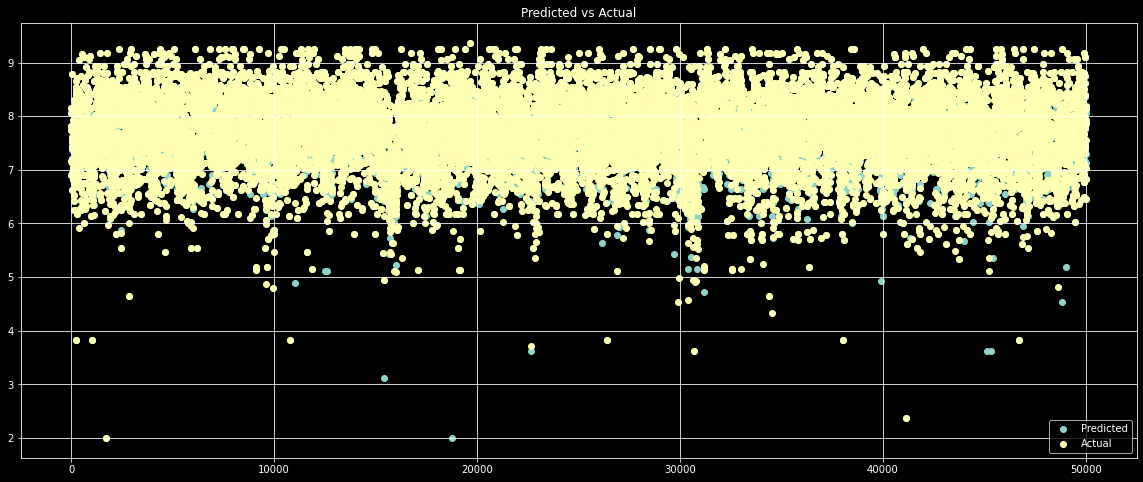


R2 Score: 89.1393%
Mean Square Error (MSE): 0.0484
Root Mean Squared Error (RMSE): 0.2199


In [52]:
compute(Y_pred,Y_test)